# Recurrent Neural Networks

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

In this class, we'll cover a new type of deep neural network layer: recurrent layers. These layer types share the common feature of having internal or **hidden state**. This makes them well-suited to sequential data, such as time series or text data. They are heavily used in Natural Language Processing, the subject of [the next class](https://supaerodatascience.github.io/deep-learning/NLP.html).

Today, we'll look at a simple example of time series forecasting. This family of algorithms can be used for a variety of prediction tasks, such as [predicting stock prices](https://arxiv.org/pdf/1911.13288.pdf) and [seizure prediction](https://www.sciencedirect.com/science/article/pii/S001048251830132X). We'll focus on the use of Recurrent Neural Networks in this context.

The data we'll use today is a set of EEG readings used to study seizures. You can find the data [here](https://physionet.org/content/chbmit/1.0.0/), and in the `data` directory there is a single patient recording `chb01_chb01_03.edf` which includes a seizure episode. We won't focus on seizure detection today but will instead try to predict neural activity.

These files are stored in the European Data Format, https://www.edfplus.info/. We'll use the python library `pyedflib` to read them.

In [1]:
!pip install pyedflib

     |████████████████████████████████| 1.2 MB 4.0 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyedflib: filename=pyEDFlib-0.1.19-cp38-cp38-macosx_10_9_x86_64.whl size=596872 sha256=1559e42363ae494d52bfa1ce3dc31f8d971dd86c1b3469636d568399499f4483
  Stored in directory: /Users/ludovic/Library/Caches/pip/wheels/89/a5/03/563ae911e909e1cf11884cb548d8491ef3627a52fb4391015f
Successfully built pyedflib


In [3]:
import os
import pyedflib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
file_name = os.path.join('data','chb01_chb01_03.edf')
f = pyedflib.EdfReader(file_name)

In [5]:
n = f.signals_in_file
labels = f.getSignalLabels()
print('%d different signals: %s' % (n, str(labels)))

23 different signals: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


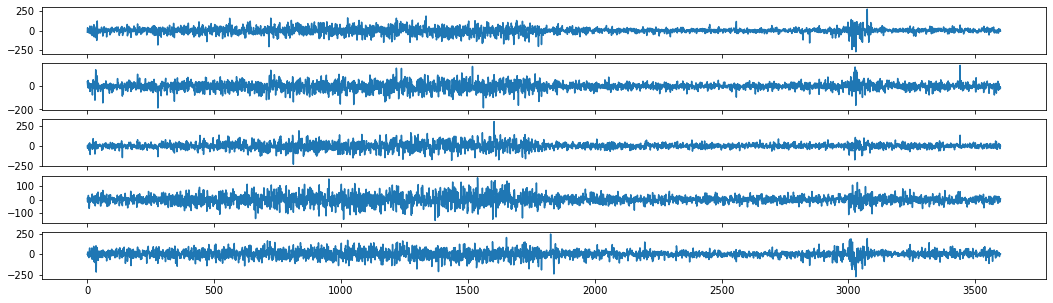

In [6]:
fig, axs = plt.subplots(5, sharex=True, figsize=(18,5))
for i in range(5):
    signal = f.readSignal(i)
    axs[i].plot(signal[::256])

As we can see, this single recording contains 23 different signals from different sensors placed. We'll focus at predicting a single signal. Our first data processing step is normalizing the data. This is beneficial for recurrent neural network training, but does require domain knowledge. In this case, we know the physical limits of the sensors, so we can use that to normalize the data between $[-1, 1]$.

In [7]:
signal = f.readSignal(0)
signal = 2 * (signal - f.physical_min(0)) / (f.physical_max(0) - f.physical_min(0)) - 1.0

Another preparation often done with timeseries data is to check if it is **stationary**, ie if the mean and variance change over time. To do this, we'll use the [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test). This test can be very costly to compute, so we'll downsample the data. There are 256 samples per second in this data, so we'll take one sample each second.

In [8]:
import statsmodels.api as sm
p_value = sm.tsa.stattools.adfuller(signal[::256])[1]
p_value

9.655290037083903e-30

The small value means that the timeseries **is stationary**. This isn't a necessary condition for LSTMs, but it will help training. When the timeseries is not stationary (`p_value > 0.05`), it's normal to instead predict the **difference** between timesteps, ie $$y_t - y_{t-1}$$ which can be calculated in numpy using `diff` and in pandas with `shift`.

Finally, we split our data into training and test sets, perserving order:

In [103]:
s_max = 1000
data = np.zeros((5, s_max))
for i in range(5):
    signal = f.readSignal(i)
    signal = 2 * (signal - f.physical_min(i)) / (f.physical_max(i) - f.physical_min(i)) - 1.0
    data[i, :] = signal[:s_max]
input = torch.from_numpy(data[:3, :-1])
target = torch.from_numpy(data[:3, 1:])
test_input = torch.from_numpy(data[3:, :-1])
test_target = torch.from_numpy(data[3:, 1:])

In [232]:
data.shape, data[:3, :-1].shape, data[:3, 1:].shape

((5, 1000), (3, 999), (3, 999))

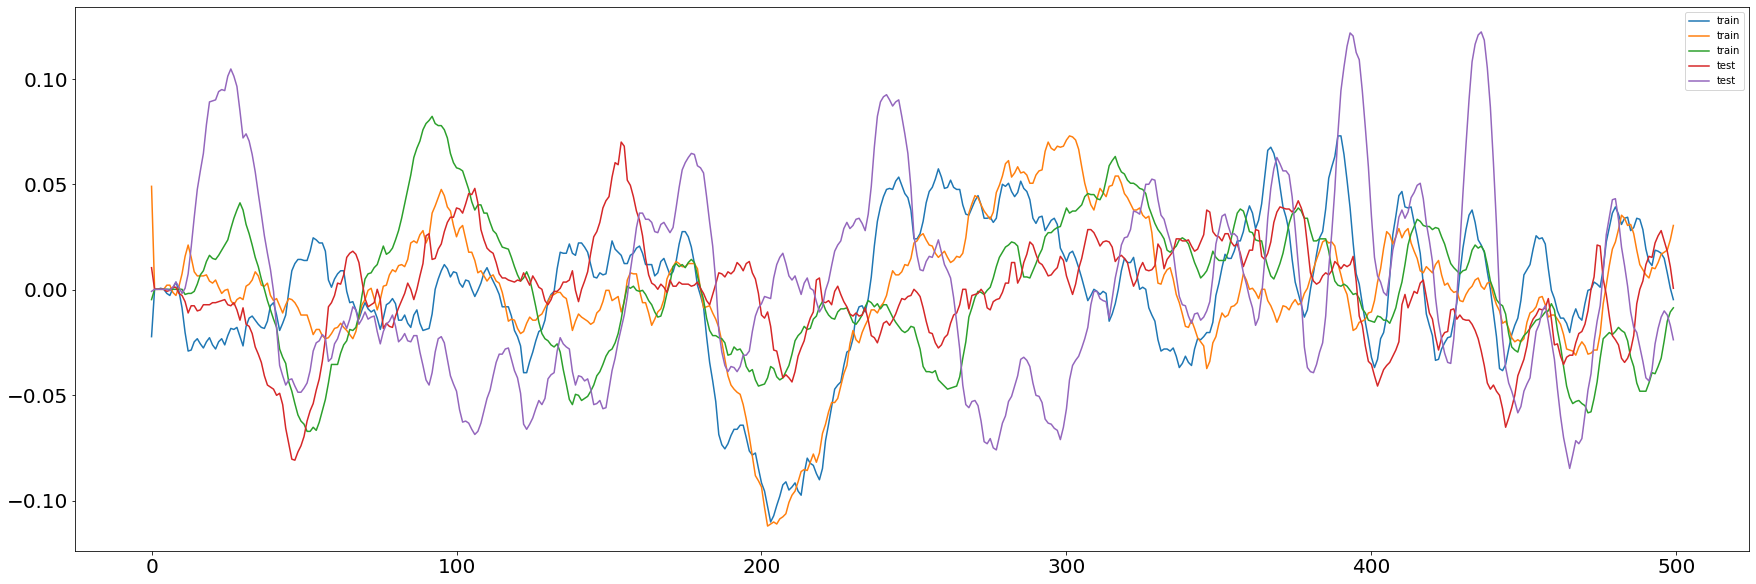

In [10]:
plt.figure(figsize=(30,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for i in range(3):
    plt.plot(input[i, :500], label='train')
for i in range(2):
    plt.plot(test_input[i, :500], label='test')
plt.legend();

We will start with a prediction which is
+ Univariate: we're using one signal to predict the future of that signal without considering other features. The opposite of this is multivariate, where multiple features are used in prediction (and multiple features can be simultaneously predicted)
+ 1-Step: we're predicting one step into the future, which can also be said as having a horizon of one sample. N-step or multi-step timeseries prediction is just an extension to this.

# Baselines

First we'll analyse the data and propose some simple baselines. We'll use **iterative prediction**, also known as walk-forward, to predict the next step at each timestep. The first baseline we'll use is called the naive baseline, which simply uses the previous value.

In [104]:
train_signal = input[0]
test_signal = target[0]

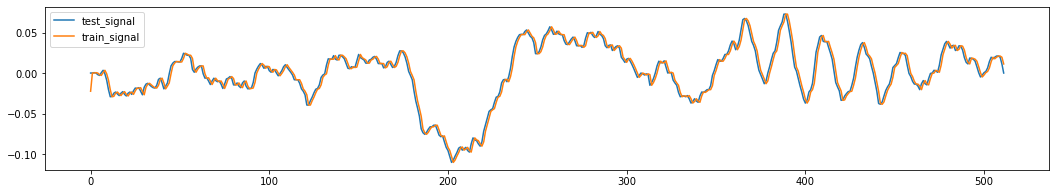

In [25]:
plt.figure(figsize=(18,3))
plt.plot(test_signal[:512], label='test_signal')
plt.plot(train_signal[:512], label='train_signal')
plt.legend();

In [12]:
# walk-forward validation
history = np.append(train_signal, np.zeros(len(test_signal)))
predictions = np.zeros(len(test_signal))
for i in range(len(test_signal)):
    t = len(train_signal) + i
    # make prediction
    predictions[i] = history[t-1]
    # observation
    history[t] = test_signal[i]

In [13]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(predictions, test_signal))

0.007971369099808836

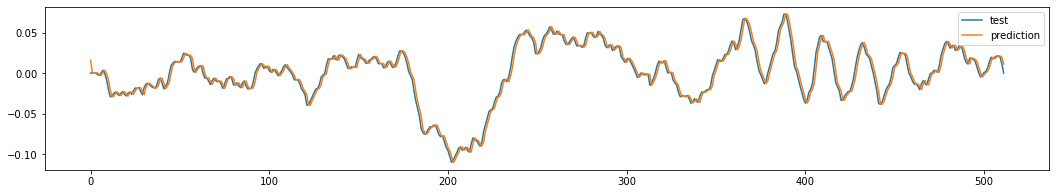

In [14]:
plt.figure(figsize=(18,3))
plt.plot(test_signal[:512], label='test')
plt.plot(predictions[:512], label='prediction')
plt.legend();

For a horizon of 1, the naive baseline is pretty good. Let's see if the historical data beyond one timestep can be useful. We'll start with a windowed approach, using the average of the past `W=5` timesteps as our prediction.

In [15]:
history = np.append(train_signal, np.zeros(len(test_signal)))
predictions = np.zeros(len(test_signal))
for i in range(len(test_signal)):
    t = len(train_signal) + i
    # make prediction
    predictions[i] = np.mean(history[t-5:t])
    # observation
    history[t] = test_signal[i]

0.02024712725037754


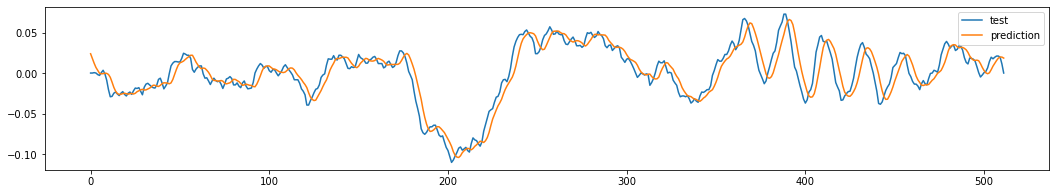

In [16]:
print(np.sqrt(mean_squared_error(predictions, test_signal)))
plt.figure(figsize=(18,3))
plt.plot(test_signal[:512], label='test')
plt.plot(predictions[:512], label='prediction')
plt.legend();

While this captures the general trend of some parts of the data, the naive baseline is still superior in terms of root mean squared error. Another approach is to exponentially decrease the dependency on past predictions, known as exponential smoothing. The rate by which we decrease past predictions is the parameter $\alpha$.

In [17]:
def exponential_smoothing(alpha):
    history = np.append(train_signal, np.zeros(len(test_signal)))
    predictions = np.zeros(len(test_signal))
    for i in range(len(test_signal)):
        t = len(train_signal) + i
        # make prediction
        if i == 0:
            predictions[i] = history[t-1]
        else:    
            predictions[i] = alpha * history[t-1] + (1 - alpha) * predictions[i-1]
        # observation
        history[t] = test_signal[i]
    return predictions

In [18]:
predictions_01 = exponential_smoothing(0.1)
print(np.sqrt(mean_squared_error(predictions_01, test_signal)))

0.027623053683837103


In [19]:
predictions_05 = exponential_smoothing(0.5)
np.sqrt(mean_squared_error(predictions_05, test_signal))

0.0136288867041948

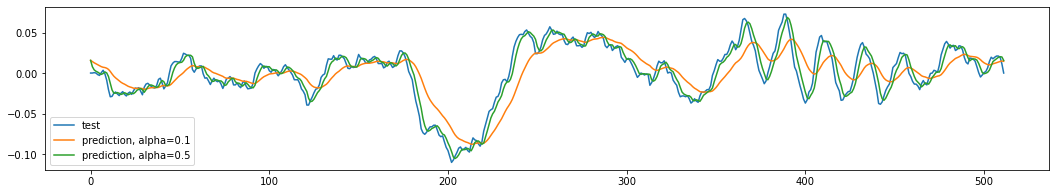

In [20]:
plt.figure(figsize=(18,3))
plt.plot(test_signal[:512], label='test')
plt.plot(predictions_01[:512], label='prediction, alpha=0.1')
plt.plot(predictions_05[:512], label='prediction, alpha=0.5')
plt.legend();

While lower alpha values help predict the general trend of our data, their RMSE is worse than using very short history. So for this EEG data, we're still struggling to make good use of the historical data to predict future data. Instead of a single parameter for history decay, we'll instead use a recurrent neural network to inform our reliance on memory for prediction, and optimize the network parameters using Stochastic Gradient Descent.

# Recurrent Neural Networks

A simple recurrent neural network layer is very similar to a fully-connected feed-forward neural network layer; it has a set of weights $W_x$ mapping the previous layer $x$ to each neuron of the recurrent layer, a bias term for each neuron, and an activation function. However, a recurrent neural network also has state; specifically, each neuron connects to every other neuron in the same layer with a time delay of 1. This means that a recurrent neural network layer has a second weight matrix $W_s$ of size $n$x$n$, where $n$ is the number of neurons in the recurrent layer.

$s_t = \tanh(W_{x} x + b_{x}  +  W_{s} s_{t-1} + b_{s})$

One way to consider these recurrent connections is by representing the previous activation functions of the recurrent layer as a hidden state, and using that hidden state as input to the network:

<img src="img/rnn.png">

Let's first observe the behavior of a single RNN layer using the `RNNCell` class from PyTorch. The documentation is [here](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html).

In [105]:
rnn = nn.RNNCell(1, 10)

In [106]:
ins = torch.randn(1, 1)
hx = torch.zeros(1, 10)
ins, hx

(tensor([[-0.5114]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [107]:
hx = rnn(ins, hx)
hx

tensor([[-0.2644, -0.4635, -0.0068, -0.4215, -0.1630, -0.2287,  0.2172, -0.5320,
          0.1645,  0.4018]], grad_fn=<TanhBackward>)

As we can see, the output of the `RNNCell` is the new hidden state. In order to predict the next value, we'll use a `Linear` model to map from this hidden state to a single output value.

In [108]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn1 = nn.RNNCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        hidden = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
        # predict over the different signals
        outputs = []
        for input_t in input.split(1, dim=1):
            hidden = self.rnn1(input_t, hidden)
            output = self.linear(hidden)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs, hidden

In [109]:
n_hidden = 16
rnn = RNN(1, n_hidden, 1).double()

In [110]:
with torch.no_grad():
    output, _ = rnn(input)
    y = output.detach().numpy()

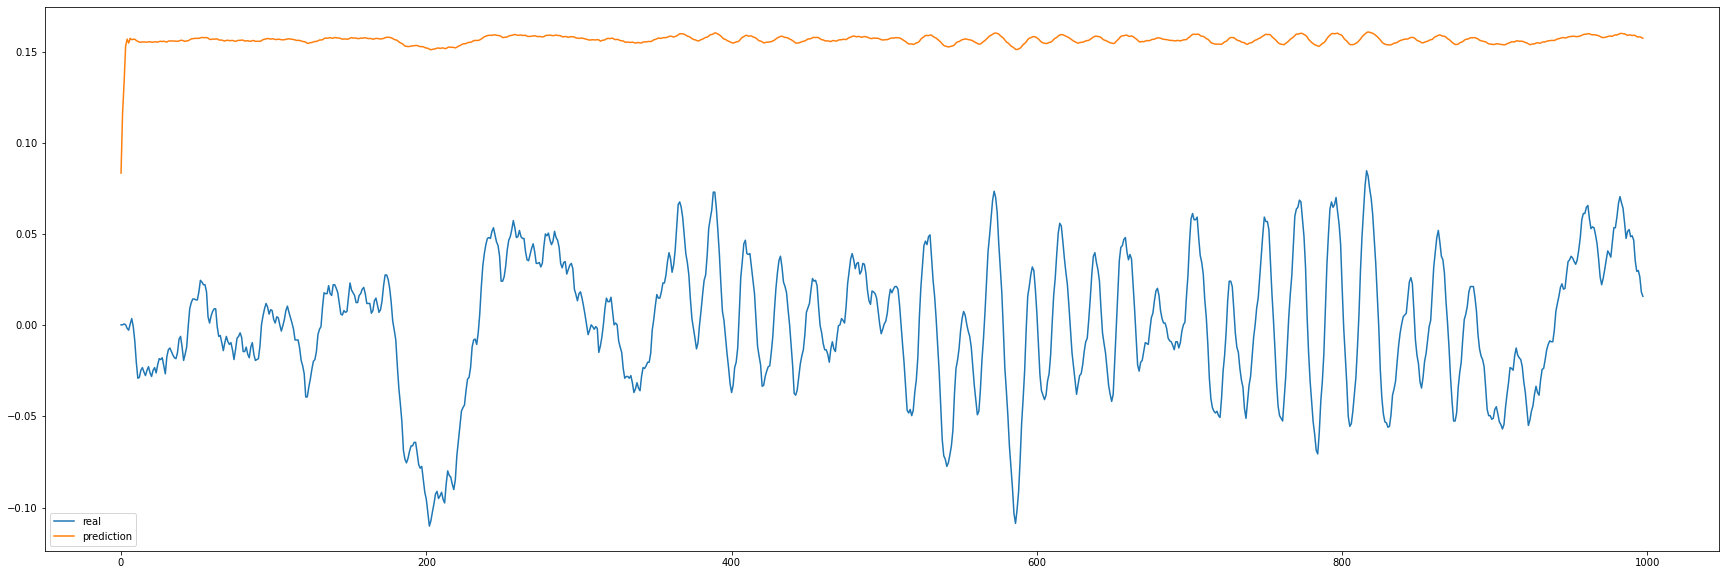

In [113]:
plt.figure(figsize=(30,10))
plt.plot(input[0, 1:], label='real')
plt.plot(y[0, :-1], label='prediction')
plt.legend()

This isn't very convincing, but remember that it is random weights. We'll soon get to training, but first let's increase the lookahead of our recurrent neural network. We'll try to predict 5 timesteps ahead.

The main difference with recurrent neural networks is that they depend on the previous state for the current state's computation. Instead of simply prediction $Y = f(x)$ as in feed-forward neural networks, recurrent networks do $Y_1 = f(x_1, f(x_0))$. Here's what an example "unrolled" RNN looks like, where the hidden state is carried over to next timestep.

<img src="img/unrolled.png">

<div class="alert alert-success">
Exercise 1
    
Include a look-ahead of `future` timesteps in your RNN model by completing the class below. Make sure to continuously update the `hidden` state.
</div>

In [118]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn1 = nn.RNNCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, future=0):
        hidden = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
        outputs = []
        for input_t in input.split(1, dim=1):
            hidden = self.rnn1(input_t, hidden)
            output = self.linear(hidden)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs, hidden

In [156]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn1 = nn.RNNCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, future=0, hidden=None):
        # accept previous hidden state
        if hidden == None:
            hidden = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)        
        outputs = []
        for input_t in input.split(1, dim=1):
            hidden = self.rnn1(input_t, hidden)
            output = self.linear(hidden)
            outputs += [output]
        for i in range(future):
            hidden = self.rnn1(output, hidden)
            output = self.linear(hidden)
            outputs += [output]
                
        outputs = torch.cat(outputs, dim=1)
        return outputs, hidden

In [562]:
# %load solutions/1_future.py
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn1 = nn.RNNCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, future=0, hidden=None):
        # accept previous hidden state
        if hidden == None:
            hidden = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
        # predict over the different signals
        outputs = []
        for input_t in input.split(1, dim=1):
            hidden = self.rnn1(input_t, hidden)
            output = self.linear(hidden)
            outputs += [output]
        for i in range(future):# if we should predict the future
            hidden = self.rnn1(output, hidden)
            output = self.linear(hidden)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs, hidden


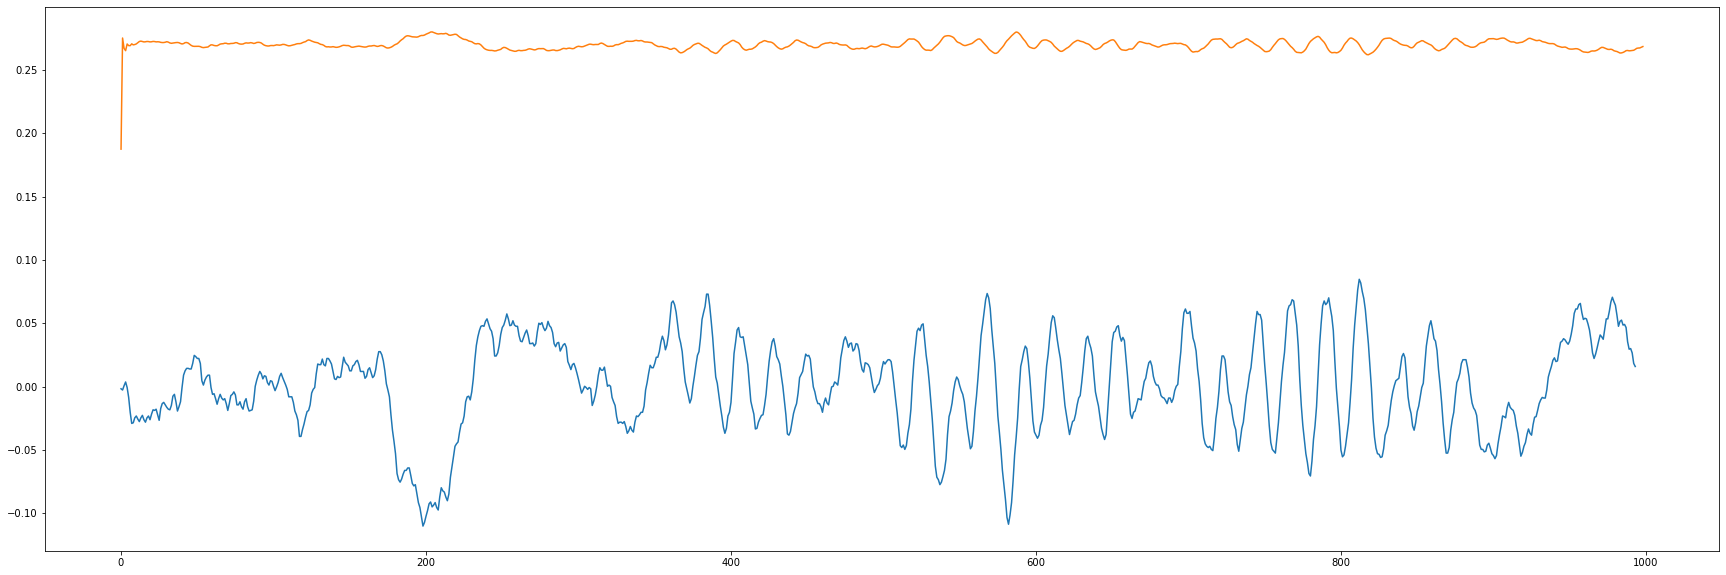

In [582]:
rnn = RNN(1, n_hidden, 1).double()
f = 5
with torch.no_grad():
    output, _ = rnn(input, future=f)
    y = output.detach().numpy()
plt.figure(figsize=(30,10))
plt.plot(input[0, f:], label='real')
plt.plot(y[0, :-f], label='prediction');

## Backpropagation through time

Our network doesn't do very well, but it's using random weights. In order to train it, we'll need to calcuate the gradient throughout the iterative process. This is known as **backpropagation through time**, and it relies on the computation of not just the current timestep, but all previous timesteps as well.

<img src="img/bptt.png">

## Test Ludo

In [563]:
a = np.array([np.linspace(0, 0.9,10) for i in range(4)])
# a[:2], a[:2,:-1], a[:2,1:]

In [564]:
a[:2].shape, a[:2,:-1].shape, a[:2,1:].shape

((2, 10), (2, 9), (2, 9))

In [565]:
inp = torch.from_numpy(a[:2,:-1])
tar = torch.from_numpy(a[:2,1:])
# inp, tar

In [566]:
inp.shape, o.shape, tar.shape

(torch.Size([2, 9]), torch.Size([2, 54]), torch.Size([2, 9]))

In [573]:
rnn = RNN(1, n_hidden, 1).double()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(rnn.parameters(), lr=0.8)
loss_history1 = []
# training step through all data
def closure1():
    optimizer.zero_grad()
    out, hidden = rnn(inp, future=5)
    loss = criterion(out[:, :-5], tar[:, :])
#     loss = criterion(out[:, 1:-4], tar[:, :])
    print('loss:', loss.item())
    loss.backward()
    loss_history1.append(loss)
    return loss

optimizer.step(closure1)

loss: 1.0109460409520818
loss: 0.7227092521475554
loss: 0.11865000977986881
loss: 0.050807476979044974
loss: 0.04842892857101039
loss: 0.03646756230841808
loss: 0.019886728719744968
loss: 0.059819016138628625
loss: 0.007626268564381866
loss: 0.006485238297838931
loss: 0.002656996040717789
loss: 0.0013043902187718625
loss: 0.0006172483484567239
loss: 0.00025031526764848457
loss: 0.0001333112585794247
loss: 0.0001071267167459649
loss: 0.00010184362117960945
loss: 9.691235917754248e-05
loss: 8.722855869433292e-05
loss: 6.83829979013833e-05


tensor(1.0109, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [568]:
rnn = RNN(1, n_hidden, 1).double()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(rnn.parameters(), lr=0.8)
loss_history2 = []
# training step through all data
def closure2():
    optimizer.zero_grad()
    out, hidden = rnn(inp, future=5)
#     loss = criterion(out[:, :-5], tar[:, :])
    loss = criterion(out[:, 1:-4], tar[:, :])
    print('loss:', loss.item())
    loss.backward()
    loss_history2.append(loss)
    return loss

optimizer.step(closure2)

loss: 0.4658523031494949
loss: 0.2830610398294686
loss: 0.06571662454669874
loss: 0.05820121976039286
loss: 0.05607103387013236
loss: 0.020484583534340003
loss: 0.008769434231044015
loss: 0.005517064747159613
loss: 0.005244521271953996
loss: 0.0035002388682208513
loss: 0.0028894858102847427
loss: 0.001184507643249362
loss: 0.0006111063020577363
loss: 0.00037933138284636117
loss: 0.000344530528981724
loss: 0.00033442076943489117
loss: 0.00033272332820961226
loss: 0.00032553393904743354
loss: 0.00029065427823670153
loss: 0.0002458292498157459


tensor(0.4659, dtype=torch.float64, grad_fn=<MseLossBackward>)

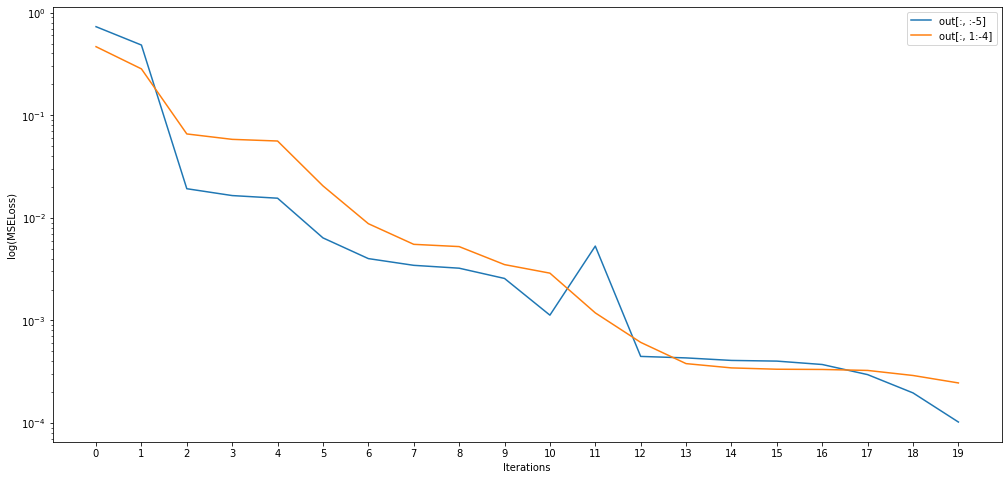

In [569]:
plt.figure(figsize=(17,8))
plt.semilogy(loss_history1, label='out[:, :-5]')
plt.semilogy(loss_history2, label='out[:, 1:-4]')
plt.xticks(range(len(loss_history2)))
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('log(MSELoss)')
plt.show()

In [574]:
with torch.no_grad():
    output, _ = rnn(inp)
    y = output.detach().numpy()

In [575]:
y[1, :-1], inp[1, 1:]

(array([0.1115758 , 0.19811806, 0.29808751, 0.39032893, 0.49693284,
        0.60543908, 0.70815126, 0.8062094 ]),
 tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000],
        dtype=torch.float64))

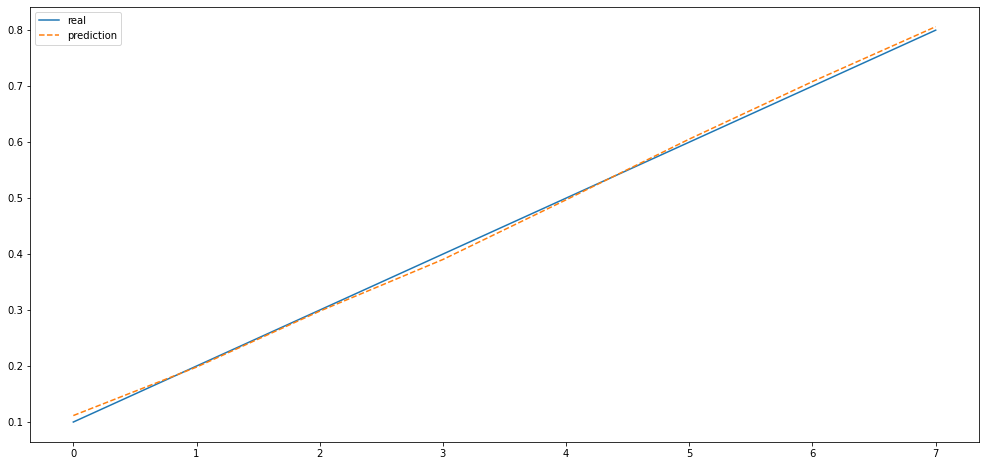

In [577]:
plt.figure(figsize=(17,8))
plt.plot(inp[1, 1:], label='real')
plt.plot(y[1, :-1], '--', label='prediction')
plt.legend()
plt.show()

## Back to class

In [297]:
rnn = RNN(1, n_hidden, 1).double()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(rnn.parameters(), lr=0.8)

In [287]:
# training step through all data
def closure():
    optimizer.zero_grad()
    out, hidden = rnn(input, future=5)
#     loss = criterion(out[:, :-10], target[:, 5:])
    loss = criterion(out[:, 1:-4], target[:, :])
#     loss = criterion(out, target)
    print('loss:', loss.item())
    loss.backward()
    return loss

In [288]:
optimizer.step(closure)

torch.Size([3, 999]) torch.Size([3, 999])
torch.Size([3, 994]) torch.Size([3, 994])
loss: 5.233633348360101e-06
torch.Size([3, 999]) torch.Size([3, 999])
torch.Size([3, 994]) torch.Size([3, 994])
loss: 5.031557989741873e-06
torch.Size([3, 999]) torch.Size([3, 999])
torch.Size([3, 994]) torch.Size([3, 994])
loss: 4.925919646411243e-06
torch.Size([3, 999]) torch.Size([3, 999])
torch.Size([3, 994]) torch.Size([3, 994])
loss: 4.6574166857364875e-06
torch.Size([3, 999]) torch.Size([3, 999])
torch.Size([3, 994]) torch.Size([3, 994])
loss: 4.594068376283166e-06
torch.Size([3, 999]) torch.Size([3, 999])
torch.Size([3, 994]) torch.Size([3, 994])
loss: 4.557742762407314e-06
torch.Size([3, 999]) torch.Size([3, 999])
torch.Size([3, 994]) torch.Size([3, 994])
loss: 4.546731652767695e-06
torch.Size([3, 999]) torch.Size([3, 999])
torch.Size([3, 994]) torch.Size([3, 994])
loss: 4.543132125955062e-06
torch.Size([3, 999]) torch.Size([3, 999])
torch.Size([3, 994]) torch.Size([3, 994])
loss: 4.53955502210

tensor(5.2336e-06, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [224]:
with torch.no_grad():
    output, _ = rnn(input)
    y = output.detach().numpy()

In [294]:
input[1].shape, y[1].shape

(torch.Size([999]), (999,))

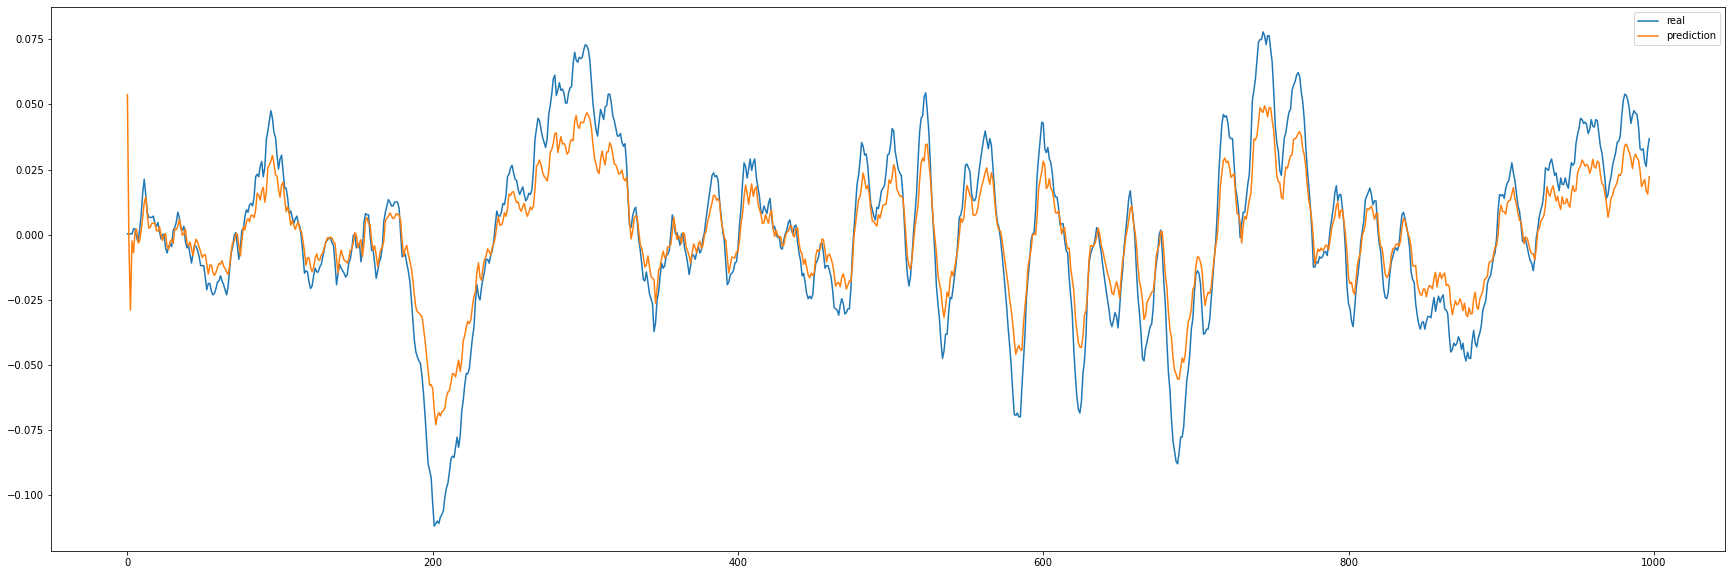

In [225]:
plt.figure(figsize=(30,10))
plt.plot(input[1, 1:], label='real')
plt.plot(y[1, :-1], label='prediction');
plt.legend()
plt.show()

<div class="alert alert-success">
Exercise 2:

Increase the look-ahead of your model during training. Make sure to align the `target` data with the output of your model (ie, advanced by `N` timesteps). How far ahead can your model predict with good accuracy?
</div>

In [ ]:
# %load solutions/2_train.py
# training step through all data
def closure():
    optimizer.zero_grad()
    out, hidden = rnn(input, future=5)
    loss = criterion(out[:, :-10], target[:, 5:])
    print('loss:', loss.item())
    loss.backward()
    return loss


# Long Short-Term Memory

A more complex recurrent neural network, which actually predates much of the current era of deep learning, is called the Long Short-Term Memory unit. This unit has multiple different internal states which are transformed to retain only the pertinent information.

Gers, Felix A., Jürgen Schmidhuber, and Fred Cummins. "Learning to forget: Continual prediction with LSTM." (1999): 850-855.

<img src='img/lstm.png'>

$$
i_t = \sigma(W_{xi}x_t + W_{hi}h_{t-1} + W_{ci}c_{t-1}+b_i)\\
f_t = \sigma(W_{xf}x_t + W_{hf}h_{t-1} + W_{cf}c_{t-1}+b_f)\\
c_t = f_tc_{t-1}+i_t\tanh(W_{xc}x_t + W_{hc}h_{t-1} + b_c)\\
o_t = \sigma(W_{xo}x_t + W_{ho}h_{t-1} + W_{co}c_{t-1}+b_o)\\
h_t = o_t\tanh(c_t)
$$

<div class="alert alert-success">
Exercise 3

Modify your model from part exercise 2 to use the PyTorch `LSTMCell` classes. Be aware of the multiple return values from an LSTM - the hidden state and cell state. The documentation is [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html). Compare your test prediction error against the RNN model and against the naive baseline. 

</div>

In [ ]:
# %load solutions/3_lstm.py

In [ ]:
lstm = LSTM(1, n_hidden, 1).double()
criterion = nn.MSELoss()
optimizer = optim.LBFGS(lstm.parameters(), lr=0.8)

In [ ]:
# training step through all data
def closure():
    optimizer.zero_grad()
    out = lstm(input)
    loss = criterion(out, target)
    print('loss:', loss.item())
    loss.backward()
    return loss

In [ ]:
optimizer.step(closure)

In [ ]:
with torch.no_grad():
    outputs = lstm(input)
    y = outputs.detach().numpy()

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(input[1, 1:], label='real')
plt.plot(y[1, :-1], label='prediction');

<div class="alert alert-info">
Truncated BPTT

So far, we've been iterating through the entire dataset each epoch. In order to split the data into batches, what would need to be done? How could the hidden state of your recurrent networks be preserved between batches?
</div>

<div class="alert alert-success">
Bonus Exercise

Another recurrent layer type is the Gated Recurrent Unit. It was designed to solve the issue of vanishing gradients in LSTMs. [Here](https://arxiv.org/pdf/1412.3555.pdf) is an empirical study of the layer types. Try replacing your LSTM with a GRU to see if it changes your results.
</div>

If you'd like to know more about time-series prediction, [this notebook](https://github.com/marcopeix/stock-prediction/blob/master/Stock%20Prediction.ipynb) gives an example of more complex classical prediction models, notably Seasonal ARIMA.

In the next class, we'll see one of the most popular uses of LSTMs currently, in the context of [Natural Language Processing](https://arxiv.org/pdf/1810.04805.pdf). Before next class, please make sure you've installed `rasa`, `gensim`, and `nest-asyncio`.